In [5]:
import os
import shutil

def create_limited_dataset(src_dir, dst_dir, max_images_per_class=1000):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
    
    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if os.path.isdir(class_path):
            dst_class_path = os.path.join(dst_dir, class_name)
            if not os.path.exists(dst_class_path):
                os.makedirs(dst_class_path)
            
            images = os.listdir(class_path)[:max_images_per_class]
            for image in images:
                src_image_path = os.path.join(class_path, image)
                dst_image_path = os.path.join(dst_class_path, image)
                shutil.copy(src_image_path, dst_image_path)

# Source and destination directories
src_data_dir = 'emotion/train'
dst_data_dir = 'emotion/limited_train'

# Create the limited dataset
create_limited_dataset(src_data_dir, dst_data_dir)

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

train_dir="emotion/limited_train"
test_dir = "emotion/test"

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 6000 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

cnn_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Epoch 1/10


c:\Users\saif\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 924s 5s/step - accuracy: 0.2637 - loss: 2.1458 - val_accuracy: 0.4299 - val_loss: 1.5061
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 880s 5s/step - accuracy: 0.4754 - loss: 1.3703 - val_accuracy: 0.4378 - val_loss: 1.4414
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 900s 5s/step - accuracy: 0.5456 - loss: 1.1983 - val_accuracy: 0.4415 - val_loss: 1.4899
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 933s 5s/step - accuracy: 0.6021 - loss: 1.0919 - val_accuracy: 0.4913 - val_loss: 1.3348
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 934s 5s/step - accuracy: 0.6592 - loss: 0.9565 - val_accuracy: 0.4837 - val_loss: 1.3872
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1111s 6s/step - accuracy: 0.7083 - loss: 0.8401 - val_accuracy: 0.4763 - val_loss: 1.4327
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 916s 5s/step - accuracy: 0.7446 - loss: 0.7334 - val_accuracy: 0.4825 - val_loss: 1.4509
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 904s 5s/step - accuracy: 0.7740 - loss: 0.6537 - val_accuracy: 0.46

In [3]:
cnn_model.save_weights('my_model.weights.h5')

In [8]:
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer('dense').output)

def extract_features(generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        features_batch = feature_extractor.predict(x_batch)
        features.append(features_batch)
        labels.append(y_batch)
    return np.vstack(features), np.vstack(labels)

train_features, train_labels = extract_features(train_generator)
test_features, test_labels = extract_features(test_generator)

train_labels_lr = np.argmax(train_labels, axis=1)
test_labels_lr = np.argmax(test_labels, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_features, train_labels_lr)


LogisticRegression(max_iter=1000)

Accuracy: 0.4845054478562332
Precision: 0.5014381656232709
Recall: 0.4845054478562332
Confusion Matrix:
[[ 445  142   55  106  143   67]
 [ 159  340   59  125  207  134]
 [ 143  132 1090  168  148   93]
 [ 190  137   84  528  229   65]
 [ 204  209   86  244  454   50]
 [  58   88   33   49   36  567]]
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.46      0.41       958
           1       0.32      0.33      0.33      1024
           2       0.77      0.61      0.69      1774
           3       0.43      0.43      0.43      1233
           4       0.37      0.36      0.37      1247
           5       0.58      0.68      0.63       831

    accuracy                           0.48      7067
   macro avg       0.48      0.48      0.48      7067
weighted avg       0.50      0.48      0.49      7067



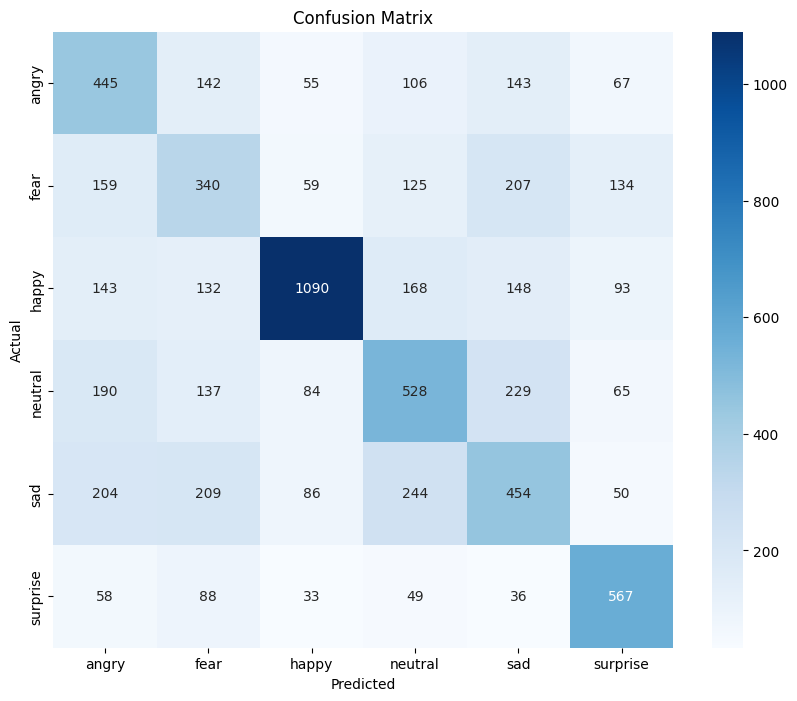

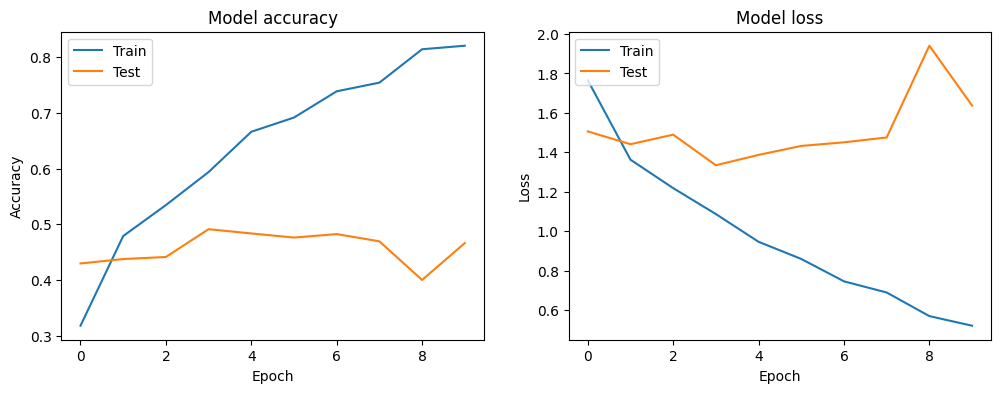

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = lr_model.predict(test_features)

accuracy = accuracy_score(test_labels_lr, y_pred)
precision = precision_score(test_labels_lr, y_pred, average='weighted')
recall = recall_score(test_labels_lr, y_pred, average='weighted')
conf_matrix = confusion_matrix(test_labels_lr, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(test_labels_lr, y_pred))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [8]:
cnn_model.save_weights('my_model.weights.h5')

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(train_features, train_labels_lr)

SVC(kernel='linear', probability=True)

Accuracy: 0.48521296165275224
Precision: 0.5009547185245536
Recall: 0.48521296165275224
Confusion Matrix:
[[ 448  141   59  103  144   63]
 [ 163  340   63  117  207  134]
 [ 150  133 1104  160  139   88]
 [ 191  132   90  527  228   65]
 [ 213  203   85  247  449   50]
 [  62   84   34   51   39  561]]
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.47      0.41       958
           1       0.33      0.33      0.33      1024
           2       0.77      0.62      0.69      1774
           3       0.44      0.43      0.43      1233
           4       0.37      0.36      0.37      1247
           5       0.58      0.68      0.63       831

    accuracy                           0.49      7067
   macro avg       0.48      0.48      0.48      7067
weighted avg       0.50      0.49      0.49      7067



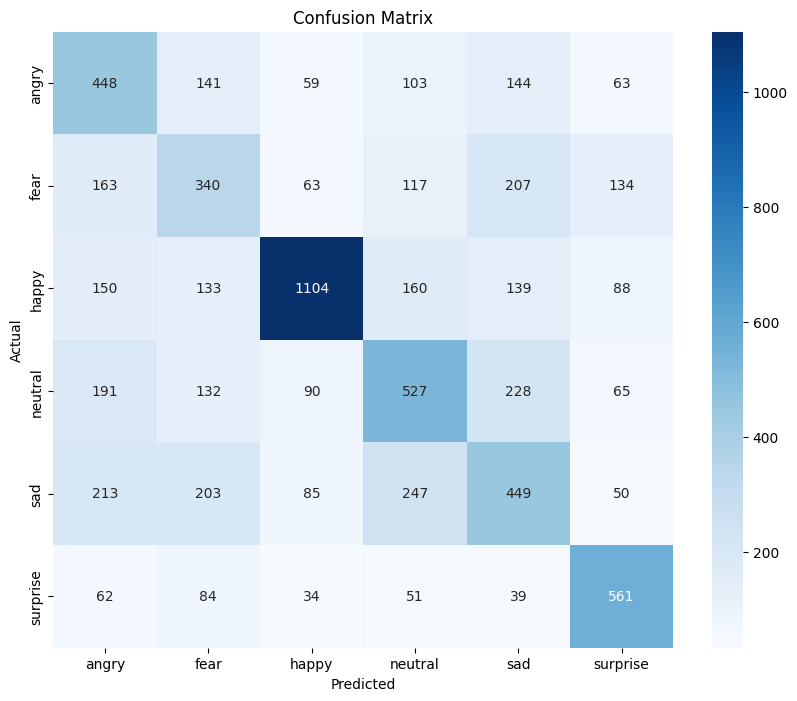

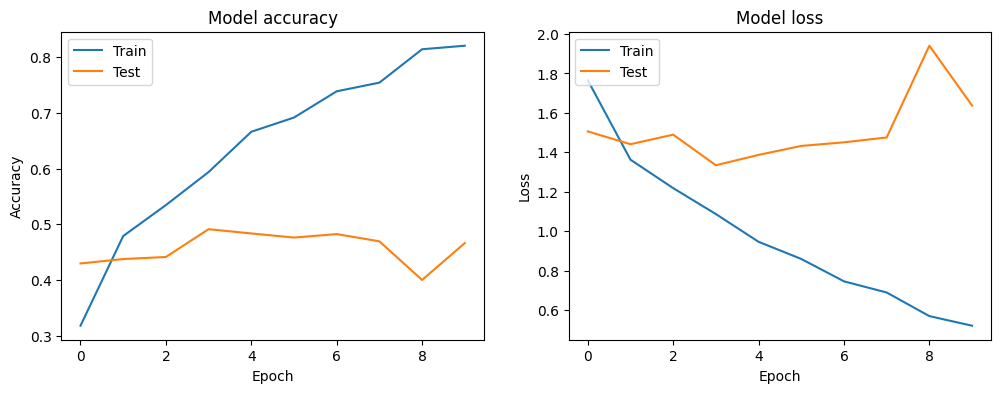

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the labels for the test set
y_pred = svm_model.predict(test_features)

# Check if labels are in binary matrix format
if len(test_labels.shape) > 1 and test_labels.shape[1] > 1:
    # Multilabel indicator format
    test_labels_multiclass = np.argmax(test_labels, axis=1)
else:
    # Multiclass format
    test_labels_multiclass = test_labels

# Convert predictions to multiclass format if needed
if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred_multiclass = np.argmax(y_pred, axis=1)
else:
    y_pred_multiclass = y_pred

accuracy = accuracy_score(test_labels_multiclass, y_pred_multiclass)
precision = precision_score(test_labels_multiclass, y_pred_multiclass, average='weighted')
recall = recall_score(test_labels_multiclass, y_pred_multiclass, average='weighted')
conf_matrix = confusion_matrix(test_labels_multiclass, y_pred_multiclass)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(test_labels_multiclass, y_pred_multiclass))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [14]:
cnn_model.save_weights('my_model.weights.h5')

In [23]:
import joblib

joblib.dump(svm_model, 'svm_model.pkl')


svm_model = joblib.load('svm_model.pkl')


In [26]:


joblib.dump(lr_model, 'la_model.pkl')


la_model = joblib.load('la_model.pkl')
